## Assignment 02 – Cryptocurrency Portfolio

Group 3: Wenlin Ye, Yifei Yin，Shufeng Li   
Github link: https: // github.com/yyin422/fall23-5700-group-3/tree/main/HW2


#### 1 Importing data and packages


In [1]:
import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests
import time
from urllib.parse import urlencode
from typing import Dict, List, Union, Optional, Any

plt.style.use('bmh')

#### 2 Gather Coin token ID information from Coinmarket, Binance, or Coinbase.
You will need to search on any of the three websites to get the token IDs. The video shows how to do it through Binance and coin market cap. A slight difference between the Binance token and the coin market token is that the Binance token adds BUSD or USDT at the end, while the CoinMarket token does not. For example, Bitcoin is represented as BTC in CoinMarket and BTCBUSD or BTCUSDT in Binance. This represents the currency conversion to a stablecoin instead of a fiat currency.

For the sake of this bit, you can choose any 30 cryptocurrencies except Bitcoin and Ethereum. Here are the categories to select from

High market cap group - this will include the most widely traded coins. We will use the top 5 coins, namely, Bitcoin (BTC-USD), Ethereum (ETH-USD), Litecoin (LTC-USD), Teather (USDT), and BNB (BNB-USD).
Mid-market cap group will include coins with a market cap between 1 billion and 20 billion. We will use the top 5 coins, namely, Cardano (ADA-USD), Polygon (MATIC-USD), Dogecoin (DOGE-USD), Ripple (XRP-USD), and Binance USD (BUSD).
The low market cap group will include coins with a market cap between 100 million and 1 billion. We will use the top 20 coins.
Make sure to list the ticker ids in a list of strings

#### 2.1 Getting Data From Binance
Create a function that takes ticker interval, start_time, and end_time as input. We want to get all the data for the selected tickers and save them in data chosen frames. There is a way to automate this by using a function as well.

For each coin/token, you will get a dataframe of daily movements from start to end. The date and time are set as the index. Close, Symbol, and index are the most critical columns, and we want to subset them in a" coins" dataframe for all the coins.
Rename close to "Coinname_closeprice." Replace the coin name with the name of the coin and token id.

In [3]:
import binance
import pandas as pd
from pandas import json_normalize


In [4]:
def binance_candle_stick(ticker: str, interval: str = '1d', start_time: Optional[int] = None, end_time: Optional[int] = None) -> pd.DataFrame:
    """Get historical data from Binance

    Args:
        ticker (str): The ticker symbol, e.g. BTCUSDT
        interval (str, optional): The price interval, '1d' ->'daily'. Defaults to '1d'.
        start (Optional[int], optional): Starting date, should be long int format. Defaults to None.

    Returns:
        pd.DataFrame: A dataframe with historical data
    """

    if start_time is None:
        start_time = int(datetime.datetime(2020, 6, 1).timestamp()*1000)
    if end_time is None:
        end_time = int(datetime.datetime.now().timestamp()*1000)

    payload = {
        'symbol': ticker,
        'interval': interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': 1000
    }
    query_string = urlencode(payload, True)
    url = 'https://api.binance.us/api/v3/klines'
    if query_string:
        url = url + '?' + query_string
    response = requests.get(url)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore']
    data = pd.DataFrame(response.json(), columns=columns, dtype=float)
    data['open_time'] = pd.to_datetime(data['open_time'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
    data.set_index('open_time', inplace=True)

    return data[['open', 'high', 'low', 'close', 'volume', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol']]

In [5]:
def obtain_binance_exchangeInfo() -> pd.DataFrame:
    """Get the exchange info from Binance"""
    url = 'https://api.binance.us/api/v3/exchangeInfo'
    response = requests.get(url)
    data = pd.json_normalize(response.json()['symbols'])

    return data

In [6]:
exchangeInfo = obtain_binance_exchangeInfo()
asset = exchangeInfo.baseAsset.unique()[2:40]

In [7]:
symbol = exchangeInfo[exchangeInfo.baseAsset.isin(asset)][exchangeInfo.quoteAsset == 'USD'].symbol.values[:30]
# symbol

/var/folders/td/59bwv_wx13sdwbggjc1r81rm0000gn/T/ipykernel_44632/4175076379.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  symbol = exchangeInfo[exchangeInfo.baseAsset.isin(asset)][exchangeInfo.quoteAsset == 'USD'].symbol.values[:30]


In [8]:

def clean_single(data:pd.DataFrame, symbol:str) -> pd.DataFrame:
    """Clean the data

    Args:
        data (pd.DataFrame): Original data
        symbol (str): The ticker symbol

    Returns:
        pd.DataFrame: Return a cleaned dataframe with only close price and symbol as column name.
    """
    data = data['close']
    data = data.rename(symbol)
    return data.reset_index()

In [9]:
# Obtain all data of the symbols
all_data = {}
for smb in symbol:
    all_data[smb] = binance_candle_stick(smb, interval = '1d')
    time.sleep(0.1)

In [10]:
all_data['BCHUSD'].head()

,open,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol
open_time,,,,,,,,,
2020-06-02 00:00:00,253.44,269.25,242.01,251.17,1758.48550,449529.2852,2325.0,992.11013,253801.7295
2020-06-03 00:00:00,250.76,253.80,246.60,253.18,635.46949,159400.3513,624.0,345.38646,86712.3188
2020-06-04 00:00:00,253.39,260.69,247.80,256.50,881.60028,225372.0124,874.0,477.01974,121609.4981
2020-06-05 00:00:00,256.43,263.04,254.53,255.90,678.38959,174886.7101,671.0,242.19525,62602.9948
2020-06-06 00:00:00,255.43,257.82,251.20,253.28,528.49909,134208.6292,462.0,294.56256,74799.2667


#### 2.2 Combining the dataframe
The updated dataframe should have the index and close price of all the coins of interest. We will use this to calculate the efficient frontier for the portfolio.

In [11]:
coins = pd.DataFrame()
for key, value in all_data.items():
    # Ensure 'open_time' is a column and not an index in value
    value = value.reset_index()
    
    # If coins DataFrame is empty, simply assign the current DataFrame value to coins
    if coins.empty:
        coins = value
        continue
    
    # Merge coins with the current DataFrame value based on 'open_time'
    coins = pd.merge(coins, value, on='open_time', how='inner')

# Convert the 'open_time' column to datetime and set it as index only after all merges are done
coins['open_time'] = pd.to_datetime(coins['open_time'], format='%Y-%m-%d %H:%M:%S')
coins.set_index('open_time', inplace=True)



/var/folders/td/59bwv_wx13sdwbggjc1r81rm0000gn/T/ipykernel_44632/3735920777.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'qav_x', 'high_x', 'taker_quote_vol_x', 'close_x', 'taker_base_vol_x', 'volume_x', 'low_x', 'num_trades_x', 'open_x'} in the result is deprecated and will raise a MergeError in a future version.
  coins = pd.merge(coins, value, on='open_time', how='inner')
/var/folders/td/59bwv_wx13sdwbggjc1r81rm0000gn/T/ipykernel_44632/3735920777.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'qav_x', 'high_x', 'taker_quote_vol_x', 'close_x', 'taker_base_vol_x', 'volume_x', 'low_x', 'num_trades_x', 'open_x'} in the result is deprecated and will raise a MergeError in a future version.
  coins = pd.merge(coins, value, on='open_time', how='inner')
/var/folders/td/59bwv_wx13sdwbggjc1r81rm0000gn/T/ipykernel_44632/3735920777.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'qav_x', 'high_x', 'taker_quote_vol_x', 'c

In [12]:
coins.head()

,open_x,high_x,low_x,close_x,volume_x,qav_x,num_trades_x,taker_base_vol_x,taker_quote_vol_x,open_y,...,taker_quote_vol_x,open_y,high_y,low_y,close_y,volume_y,qav_y,num_trades_y,taker_base_vol_y,taker_quote_vol_y
open_time,,,,,,,,,,,,,,,,,,,,,
2020-06-23,242.25,244.28,239.38,240.49,183.29164,44321.8087,322.0,92.03304,22256.9924,44.37,...,39872.1429,2.5726,2.5899,2.5683,2.5683,1024.18,2642.9488,33.0,789.47,2037.7954
2020-06-24,240.16,245.09,230.00,232.51,416.29881,98497.0753,629.0,166.32068,39466.1529,44.19,...,25486.0215,2.5715,2.5973,2.4800,2.4868,4450.94,11362.6596,114.0,3097.00,7925.5204
2020-06-25,232.52,234.57,226.19,232.33,198.95030,46178.2788,276.0,53.59672,12436.9729,42.49,...,42762.5933,2.5137,2.5137,2.4671,2.4801,433.94,1081.1306,20.0,305.17,760.4697
2020-06-26,230.95,233.17,228.12,230.82,188.70994,43602.7461,397.0,69.51320,16019.9054,42.24,...,7287.9616,2.4750,2.5056,2.4201,2.4867,2653.39,6533.9193,84.0,1287.73,3160.4356
2020-06-27,229.75,231.22,200.01,216.05,953.67012,204255.4208,720.0,409.01277,87491.5878,42.93,...,58517.1474,2.4867,2.4868,2.2795,2.3365,4009.03,9394.9744,145.0,2664.61,6195.0610


#### 3. Calculating the Efficient Frontier
To calculate an efficient frontier, we will need to calculate each coin's means, standard deviations, and covariances.

Calculate the mean of the dataframe generated in 2.2 using pd.df.mean() method
Calculate the covariance matrix of the dataframe generated in 2.2 using pd.df.cov() method
Use the function in the video to generate a complete crypto portfolio for $10,000.

In [16]:
def calc_daily_returns(df):
    return (df.pct_change())
 #calculate the daily percent change between the 
 
coin_daily_returns = calc_daily_returns(coins)
coin_daily_returns.head()


,open_x,high_x,low_x,close_x,volume_x,qav_x,num_trades_x,taker_base_vol_x,taker_quote_vol_x,open_y,...,taker_quote_vol_x,open_y,high_y,low_y,close_y,volume_y,qav_y,num_trades_y,taker_base_vol_y,taker_quote_vol_y
open_time,,,,,,,,,,,,,,,,,,,,,
2020-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-24,-0.008627,0.003316,-0.039185,-0.033182,1.271237,1.222316,0.953416,0.807184,0.773202,-0.004057,...,-0.360806,-0.000428,0.002857,-0.034381,-0.031733,3.345857,3.299236,2.454545,2.922885,2.889262
2020-06-25,-0.031812,-0.042923,-0.016565,-0.000774,-0.522097,-0.531171,-0.561208,-0.677751,-0.684870,-0.038470,...,0.677884,-0.022477,-0.032187,-0.005202,-0.002694,-0.902506,-0.904852,-0.824561,-0.901463,-0.904048
2020-06-26,-0.006752,-0.005968,0.008533,-0.006499,-0.051472,-0.055774,0.438406,0.296967,0.288087,-0.005884,...,-0.829572,-0.015396,-0.003222,-0.019051,0.002661,5.114647,5.043599,3.200000,3.219714,3.155899
2020-06-27,-0.005196,-0.008363,-0.123225,-0.063989,4.053630,3.684462,0.813602,4.883958,4.461430,0.016335,...,7.029289,0.004727,-0.007503,-0.058097,-0.060401,0.510909,0.437877,0.726190,1.069230,0.960192


In [17]:
def calc_mean_daily_returns(daily_returns):
    return(daily_returns.mean())
# calculate the mean daily returns for each coin
coin_mean_daily_returns = calc_mean_daily_returns(coin_daily_returns)
coin_mean_daily_returns

open_x               0.000908
high_x               0.000515
low_x                0.001174
close_x              0.000929
volume_x             0.309852
                       ...   
volume_y             0.429855
qav_y                0.436610
num_trades_y         0.218940
taker_base_vol_y     0.508963
taker_quote_vol_y    0.514928
Length: 270, dtype: float64

In [18]:
def calc_covariance_matrix(daily_returns):
    return (daily_returns.cov())
crypto_cov_matrix = calc_covariance_matrix(coin_daily_returns)
print(crypto_cov_matrix)

                     open_x    high_x     low_x   close_x  volume_x     qav_x  \
open_x             0.003095  0.001422  0.001046 -0.000299  0.004882  0.006441   
high_x             0.001422  0.002277  0.000913  0.001378  0.018404  0.022134   
low_x              0.001046  0.000913  0.003340  0.001764 -0.012140 -0.008415   
close_x           -0.000299  0.001378  0.001764  0.003073  0.003300  0.007567   
volume_x           0.004882  0.018404 -0.012140  0.003300  1.333353  1.353762   
...                     ...       ...       ...       ...       ...       ...   
volume_y           0.007004  0.011066 -0.011597 -0.004061  0.670196  0.659098   
qav_y              0.008364  0.013194 -0.008123 -0.001103  0.667400  0.663224   
num_trades_y       0.004974  0.010082 -0.008443  0.000016  0.435262  0.433515   
taker_base_vol_y   0.003729  0.008834 -0.012032 -0.002211  0.561763  0.549805   
taker_quote_vol_y  0.005201  0.011015 -0.008532  0.000786  0.557442  0.552127   

                   num_trad

In [124]:
def portfolio_statistics(coins, number_portfolios, mean_daily_returns, cov_matrix):
    len_coins=len(coins)
    results_temp = np.zeros( (4+270-1, number_portfolios))
    for i in range(number_portfolios):# select random weights for portfolio holdings
        weights = np.array(np.random.random(len_coins))
        weights2 = np.array(np.random.random(270))

# rebalance weights to sum to 1
        weights2 /= np.sum(weights2)
# calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights2) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights2.T, np.dot(cov_matrix,weights2))) * np.sqrt(252)
# 3month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139
# store results in results arrayresults 
        results_temp[0, i]= portfolio_return
        results_temp[1, i] = portfolio_std_dev
# store sharpe Ratio (returnvolatilitynisk free rate element excluded forsimplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
# iterate through the weight vector and add data to results array
        for j in range(len(weights2)):
                results_temp[j+3, i] = weights2[j]
    print(results_temp.shape)
# convert results array to Pandas DataFramesharpe'
    results_df = pd.DataFrame(results_temp.T)
    return(results_df)


In [125]:
number_portfolios = 10000
crypto_results = portfolio_statistics(coins, number_portfolios, coin_mean_daily_returns, crypto_cov_matrix)
crypto_results.head(15)


(273, 10000)


,0,1,2,3,4,5,6,7,8,9,...,263,264,265,266,267,268,269,270,271,272
0,47.161044,6.182767,7.625574,0.002421,0.006819,0.000566,0.003931,0.006232,0.006048,0.006061,...,0.001923,0.004610,0.002284,0.002083,0.000030,0.002537,0.001975,0.000663,0.004108,0.005474
1,48.385690,6.398141,7.560289,0.006395,0.004645,0.000010,0.005273,0.001263,0.000970,0.004502,...,0.002129,0.001910,0.002299,0.005471,0.003262,0.003484,0.005914,0.000118,0.003485,0.005486
2,47.094253,6.630025,7.101083,0.001522,0.001395,0.000767,0.003845,0.005446,0.001339,0.002377,...,0.001022,0.000253,0.006475,0.007024,0.002613,0.001904,0.002278,0.004303,0.001168,0.000601
3,44.070306,6.594015,6.681272,0.005453,0.004999,0.004371,0.002440,0.001329,0.001692,0.004642,...,0.006519,0.004293,0.004672,0.001794,0.006066,0.003632,0.003403,0.007041,0.001012,0.004474
4,46.861030,5.774546,8.112695,0.001271,0.004296,0.007079,0.003584,0.004119,0.006886,0.005263,...,0.002750,0.004682,0.002087,0.005947,0.003196,0.003449,0.003847,0.005621,0.003932,0.004186
5,46.924732,6.765931,6.933389,0.005167,0.003910,0.002311,0.005140,0.000119,0.004387,0.003812,...,0.006872,0.005492,0.002377,0.006458,0.002073,0.005616,0.000074,0.006296,0.001185,0.006047
6,47.748147,6.484568,7.361207,0.005682,0.001311,0.004981,0.001883,0.000274,0.006978,0.004256,...,0.005601,0.002956,0.002433,0.002484,0.001353,0.007142,0.001224,0.006997,0.006366,0.005823
7,45.638486,5.511380,8.278250,0.003561,0.004713,0.000567,0.000888,0.000360,0.003951,0.005033,...,0.003947,0.000632,0.004594,0.003721,0.000198,0.005574,0.004302,0.005039,0.006734,0.005584
8,47.015570,6.320739,7.436103,0.007054,0.004339,0.002491,0.000162,0.002300,0.003400,0.007352,...,0.002323,0.001252,0.004485,0.001681,0.002222,0.003243,0.007426,0.000769,0.005779,0.003304
9,48.713942,6.161981,7.903309,0.002354,0.006865,0.000837,0.000259,0.004569,0.002073,0.001598,...,0.000549,0.004933,0.004198,0.007283,0.007463,0.002458,0.003179,0.005900,0.005401,0.001143


#### 4. Locate the Best portfolios
The percentages returned from the best portfolio search represent the total assets added to each coin from the $10, 000.

#### 4.1 Locate the position of the portfolio with the highest Sharpe Ratio

In [128]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df[2].idxmax()]
crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
crypto_max_sharpe_portfolio

0      48.685987
1       5.661052
2       8.597711
3       0.002842
4       0.000471
         ...    
268     0.001541
269     0.004292
270     0.002809
271     0.003369
272     0.005549
Name: 3019, Length: 273, dtype: float64

#### 4.2 Locate the portfolio with the lowest volatility


In [129]:
def min_volatility(results_df):
#"""locate portfolio with lowest volatility"""
    return results_df.iloc[results_df[1].idxmin()]
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

0      40.333767
1       4.867333
2       8.283770
3       0.007338
4       0.002067
         ...    
268     0.000058
269     0.006755
270     0.007143
271     0.006178
272     0.005393
Name: 9576, Length: 273, dtype: float64


#### 4.3 Plot the efficient portfolio

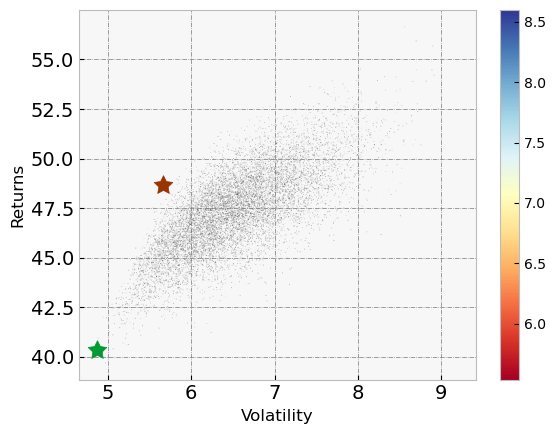

In [134]:

def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 1, y=0, s = 50,
                         c=results_df[2], cmap='RdYlBu',edgecolors='.1')
    ax.grid( color='#777777', linestyle= '-.', linewidth=0.5)
    ax.set_facecolor('#f7f7f7')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)
        # # plot red star to highlight the position of the portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='#993300', s= 200)
        # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='#009933', s = 200)
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show()